# 🚀 Module 3: Model Packaging and Deployment on Kubernetes

In this module, we will:
1. Load the Trained Model from MLflow Server
2. Deploy the model locally using mlflow model server
3. Test the locally deployed model
4. Build a REST API for model inference using FastAPI
5. Create a Containerfile to containerize the service
6. Deploy the container to a Kubernetes cluster (i.e. OpenShift)
7. Test the Model-API

Make sure MLflow is installed in your environment:

```bash
pip install mlflow
```

In [2]:
# Install requirements
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 207.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 190.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 236.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.2/573.2 kB 380.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 206.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 269.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 257.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 254.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 416.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 571.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 489.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

## 📦 Import Required Libraries

Before we proceed with training and tracking our machine learning model, we need to import the necessary libraries.


In [12]:
# Import necessary modules
import os
import joblib

import requests
import json

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

## 🧳 Select and Load a trained Model Version from MLflow

In this step, we interact with the MLflow Model Registry to:

1. **List all available versions** of a registered model (`BikeSharingModel`) along with their metadata, such as version number, stage, and run ID.
2. **Prompt the user** to choose a specific version to use for deployment or analysis.
3. **Load the selected model** from the MLflow tracking server using the model URI.

This makes it easy to manage multiple iterations of a model and ensures reproducibility when deploying or testing specific versions.

In [2]:
# Initialize MLflow client
MLFLOW_TRACKING_URI = 'https://mlflow-mlflow.apps.cluster-x5r72.dynamic.redhatworkshops.io'
mlflow.set_tracking_uri(f"{MLFLOW_TRACKING_URI}")
client = MlflowClient()

model_name = "BikeSharingModel"

# List available versions
versions = client.search_model_versions(filter_string=f"name='{model_name}'", order_by=["version_number DESC"])

print("📦 Available versions for model:", model_name)
for v in versions:
    print(f"Version: {v.version}, Stage: {v.current_stage}, Status: {v.status}, Run ID: {v.run_id}")

# Ask the user to select a version
selected_version = input("Enter the version number you want to download: ").strip()

# Load the selected model version
model_uri = f"models:/{model_name}/{selected_version}"
model = mlflow.pyfunc.load_model(model_uri=model_uri)

print(f"✅ Model version {selected_version} loaded successfully from MLflow.")

📦 Available versions for model: BikeSharingModel
Version: 1, Stage: None, Status: READY, Run ID: a7750d532dd641e78c6c7879cc1b79ac


Enter the version number you want to download:  1


✅ Model version 1 loaded successfully from MLflow.


## 📥 Loading Sample Data for Inference
In this section, we load a set of prepared input samples that will be used for testing the deployed machine learning model. The data is read from a CSV file located in the ./data/test_model/ directory.

In [3]:
# Prepare 5 samples as inference inputs
test_model_path = "./data/test_model/"

# Read sample input CSV file
sample_input = pd.read_csv(test_model_path + 'sample_input_data.csv')

# sample_input.to_dict(orient ='split')
sample_input.head()

,dteday,instant,season,year,month,hour,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-02-25,1247,1,0,2,1,0,5,1,2,0.32,0.3485,1.00,0.0000,1,9,10
1,2011-02-16,1055,1,0,2,16,0,3,1,1,0.46,0.4545,0.31,0.3881,26,96,122
2,2011-01-02,36,1,0,1,12,0,0,0,2,0.36,0.3333,0.66,0.2985,20,73,93
3,2011-02-14,1002,1,0,2,9,0,1,1,1,0.40,0.4091,0.37,0.3881,8,122,130
4,2011-02-04,766,1,0,2,8,0,5,1,1,0.14,0.1515,0.74,0.1343,3,217,220


In [4]:
# We define the sample inputs using the same numerical and categorical features 
# used for model training
numerical_features=['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'weekday']
categorical_features=['season', 'holiday', 'workingday']

sample_X_input = sample_input[numerical_features + categorical_features]
sample_y_input = sample_input["count"]

sample_X_input.head()

,temp,atemp,humidity,windspeed,hour,weekday,season,holiday,workingday
0,0.32,0.3485,1.00,0.0000,1,5,1,0,1
1,0.46,0.4545,0.31,0.3881,16,3,1,0,1
2,0.36,0.3333,0.66,0.2985,12,0,1,0,0
3,0.40,0.4091,0.37,0.3881,9,1,1,0,1
4,0.14,0.1515,0.74,0.1343,8,5,1,0,1


## 🚀 Local Deployment: Test the MLflow Model Server

To verify that the registered model works correctly, we serve it locally using MLflow’s model server, while still using the remote MLflow tracking server.

- Run the following commands in Git Bash or your terminal:
  ````sh
      mlflow models serve -m "models:/MODEL_NAME/MODEL_VERSION" --env-manager local --no-conda
  ````
    
    - Replace MODEL_NAME and MODEL_VERSION with your actual model name and version number.

    - The --env-manager local flag tells MLflow to use your current Python environment.

    - --no-conda skips creating a new Conda environment.
 
- Once the server is running, you can send prediction requests to:

    ````sh
    http://127.0.0.1:5000/invocations
    ````

In [5]:
# Prepare the inference Requests
inference_request = {
    "dataframe_split": 
        sample_X_input.to_dict(orient ='split')
}

###  Send Prediction Request and Compare Model Output with Actual Results

This code sends a prediction request to a locally deployed model and retrieves the prediction results if the request is successful. It then combines the predicted counts with the actual counts from the test data and prints the comparison, or reports an error if the request fails.

In [6]:
# Send a prediction request to the locally depoloyed model
endpoint = "http://127.0.0.1:5000/invocations"
response = requests.post(endpoint, json=inference_request)

# print(response.json()['predictions'].int())

# Check if the response is successful
if response.status_code == 200:
    # Process the prediction response
    predictions = pd.DataFrame(response.json()['predictions'], columns=['Predicted Count'])

    # Combine predictions with actual classes
    actual_class_test = sample_y_input.reset_index(drop=True)
    model_output = pd.concat([predictions, actual_class_test], axis=1)

    # Rename columns for clarity
    model_output.columns = ['Predicted Count', 'Actual  Count']

    # Display the final output
    print(model_output)
    
else:
    print(f"Request failed with status code: {response.status_code}")
    print(f"Response content: {response.text}")

   Predicted Count  Actual  Count
0             8.56             10
1           120.97            122
2            90.67             93
3           137.45            130
4           209.46            220


### 📊 Visualizing Actual vs Predicted Counts for Sample Inputs

This cell visualizes the predicted versus actual bike rental counts for each input sample using a scatter plot. Squares represent the actual values, while crosses indicate the model’s predictions, making it easy to spot discrepancies. This side-by-side comparison helps evaluate how closely the model aligns with real-world outcomes for the selected test samples.

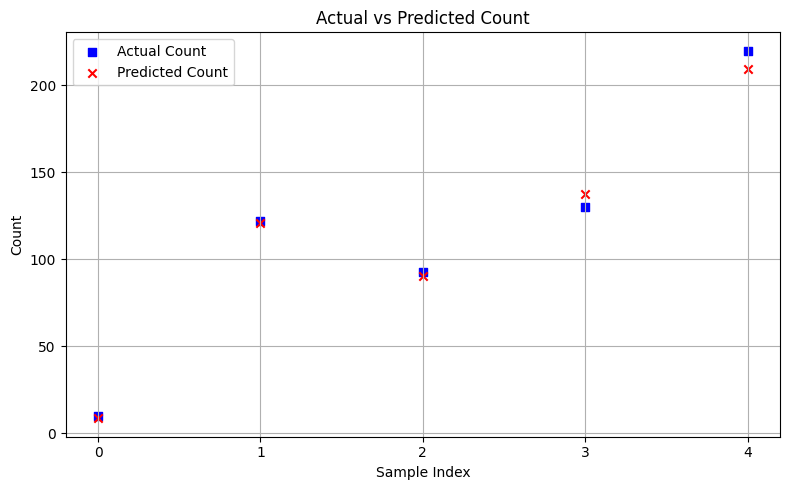

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples
x = np.arange(len(model_output))

plt.figure(figsize=(8, 5))

# Plot actual values as squares
plt.scatter(x, model_output['Actual  Count'], label='Actual Count', marker='s', color='blue')

# Plot predicted values as crosses
plt.scatter(x, model_output['Predicted Count'], label='Predicted Count', marker='x', color='red')

plt.xlabel("Sample Index")
plt.ylabel("Count")
plt.title("Actual vs Predicted Count")
plt.xticks(x)  # Show sample indices clearly
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🛠️ Create a REST API using FastAPI
This API will load the model and expose an endpoint for predictions.

In [8]:
%%writefile ./models/app.py
# ./models/app.py
import os
from fastapi import FastAPI, HTTPException
import pandas as pd
import mlflow
from mlflow.pyfunc import PyFuncModel

# ── 1. Read configuration from environment ──────────────────────────────
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI") # e.g. "https://mlflow-mlflow.apps.cluster-x5r72.…"
MODEL_NAME = os.getenv("MODEL_NAME") or "BikeSharingModel"
MODEL_VERSION = os.getenv("MODEL_VERSION") # e.g. "5"  (optional)

if not MLFLOW_TRACKING_URI:
    raise RuntimeError("MLFLOW_TRACKING_URI environment variable not set")

if not MODEL_VERSION:
    raise RuntimeError("MODEL_VERSION environment variable not set!")

# ── 2. Connect to MLflow and load the model once at startup ─────────────
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# load a specific version
model_uri = f"models:/{MODEL_NAME}/{MODEL_VERSION}"

model: PyFuncModel = mlflow.pyfunc.load_model(model_uri)

# ── 3. API definition ───────────────────────────────────────────────────
app = FastAPI(title="Bike-Sharing Predictor",
              description=f"Served from {model_uri} at {MLFLOW_TRACKING_URI}",
              version="1.0.0")

@app.post("/predict")
def predict(features: dict):
    """
    Accepts a JSON object of feature names / values
    and returns a single prediction.
    """
    try:
        df = pd.DataFrame([features])
        prediction = float(model.predict(df)[0])  # ensure JSON-serialisable
        return {"prediction": prediction}
    except Exception as exc:
        raise HTTPException(status_code=400, detail=str(exc))

Overwriting ./models/app.py


## 📦 Containerize the FastAPI Application
Create a Containerfile for the FastAPI app.

In [9]:
%%writefile ./models/Containerfile
# ./models/Containerfile
FROM python:3.11-slim

# ── Install OS dependencies (optional but helpful) ───────────────────────
RUN apt-get update && apt-get install -y --no-install-recommends \
        build-essential         \
    && rm -rf /var/lib/apt/lists/*

# ── Set workdir and copy application code ────────────────────────────────
WORKDIR /app
COPY app.py ./

# ── Install Python requirements ──────────────────────────────────────────
# mlflow pulls in scikit-learn, pandas, etc.  --no-cache-dir keeps image small
RUN pip install --no-cache-dir fastapi uvicorn[standard] mlflow pandas

# ── Environment variables with sensible defaults (override at runtime) ──
ENV MLFLOW_TRACKING_URI=""
ENV MODEL_NAME=BikeSharingModel
# Leave MODEL_VERSION blank to pick the latest Production version
ENV MODEL_VERSION=""

# ── Entrypoint ───────────────────────────────────────────────────────────
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]

Overwriting ./models/Containerfile


## 🚀 Deployment on OpenShift Cluster: Test the Model-API
In this section, we deploy the trained machine learning model on an OpenShift cluster. The deployment includes building a container image, deploying it via a deployment manifest, and exposing it using an internal service.

- Create the Container Image Using a BuildConfig
- Deploy the Image Using k8s_deployment.yaml
- Expose the Model Internally via a Service

## 🧱 Kubernetes Manifests: Deployment and Service

In [10]:
%%writefile ./models/k8s_deployment.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: bike-model-api
  labels:
    app: bike-model-api
spec:
  replicas: 1
  selector:
    matchLabels:
      app: bike-model-api
  template:
    metadata:
      labels:
        app: bike-model-api
    spec:
      containers:
        - name: bike-model-container
          image: image-registry.openshift-image-registry.svc:5000/bike-demand-model/bike-demand:v1
          ports:
            - containerPort: 8000
          env:
            - name: MLFLOW_TRACKING_URI
              value: "https://mlflow-mlflow.apps.cluster-x5r72.dynamic.redhatworkshops.io"
            - name: MODEL_NAME
              value: "BikeSharingModel"
            - name: MODEL_VERSION
              value: "1"  # Or leave it empty for latest Production version
          resources:
            requests:
              cpu: "250m"
              memory: "256Mi"
            limits:
              cpu: "500m"
              memory: "512Mi"
---
apiVersion: v1
kind: Service
metadata:
  name: bike-model-api
spec:
  selector:
    app: bike-model-api
  ports:
    - protocol: TCP
      port: 80
      targetPort: 8000
  type: ClusterIP

Writing ./models/k8s_deployment.yaml


## 🧪 Test the API Endpoint

First, we prepare the sample input data for inferencing. We load a CSV file containing sample test data and prepare it in the format expected by the deployed machine learning model.

In [13]:
# Load the sample data CSV
test_model_path = "./data/test_model/"

df = pd.read_csv(test_model_path + 'sample_input_data.csv')
# df = pd.read_csv("sample_input_data.csv")

# Define the subset of features expected by the model
model_features = [
    'temp', 'atemp', 'humidity', 'windspeed',
    'hour', 'weekday', 'season', 'holiday', 'workingday'
]

# Extract the relevant subset and convert to JSON-like list of dicts
subset_df = df[model_features]
json_input_list = subset_df.head(5).to_dict(orient='records')

# print(json_input_list)

# Store the generated sample inference input
output_file  = f"{test_model_path}json_input_list.txt"
with open(output_file, "w") as f:
    for item in json_input_list:
        f.write(json.dumps(item) + "\n")

print(f"Saved to {output_file}")

Saved to ./data/test_model/json_input_list.txt


### Sending a Test Inference Request via curl

This command sends a test HTTP POST request to the deployed model’s prediction endpoint with a single sample input in JSON format, allowing you to verify that the model is correctly receiving and processing inference requests within the OpenShift cluster.

In [14]:
!curl -X POST http://bike-model-api.bike-demand-model.svc.cluster.local:80/predict \
  -H "Content-Type: application/json" \
  -d '{"temp": 0.32, "atemp": 0.3485, "humidity": 1.0, "windspeed": 0.0, "hour": 1, "weekday": 5, "season": 1, "holiday": 0, "workingday": 1}'

{"prediction":8.56}

### Batch Inference: Sending Multiple Requests to the Model Endpoint

This section reads multiple JSON-formatted input samples from a file and sends them one-by-one to the model's prediction endpoint. It collects the predicted results and displays them alongside the actual target values in a combined output DataFrame.

In [16]:
import json
import requests
import pandas as pd

# ── Endpoint ─────────────────────────────────────────────────────────────
endpoint = "http://bike-model-api.bike-demand-model.svc.cluster.local:80/predict"

# ── Read the JSON-line file and send requests ────────────────────────────
predictions = []

with open(f"{test_model_path}json_input_list.txt") as fh:
    for line_no, line in enumerate(fh, 1):
        line = line.strip()
        
        inference_request = json.loads(line)
        response = requests.post(endpoint, json=inference_request)

        if response.status_code == 200:
            # FastAPI returns {"prediction": <value>}
            predictions.append(response.json()["prediction"])

        else:
            print(f"Request failed with status code: {response.status_code}")
            print(f"Response content: {response.text}")

# ── Assemble results into a DataFrame ────────────────────────────────────
pred_df = pd.DataFrame(predictions, columns=["Predicted Count"])

# Combine predictions with actual classes
actual_class_test = sample_y_input.reset_index(drop=True)
model_output = pd.concat([pred_df, actual_class_test], axis=1)

# Rename columns for clarity
model_output.columns = ['Predicted Count', 'Actual  Count']

# Display the final output
print(model_output)

   Predicted Count  Actual  Count
0             8.56             10
1           120.97            122
2            90.67             93
3           137.45            130
4           209.46            220


### 📊 Visualizing Actual vs Predicted Counts for Sample Inputs

This cell visualizes the predicted versus actual bike rental counts for each input sample using a scatter plot. Squares represent the actual values, while crosses indicate the model’s predictions, making it easy to spot discrepancies. This side-by-side comparison helps evaluate how closely the model aligns with real-world outcomes for the selected test samples.

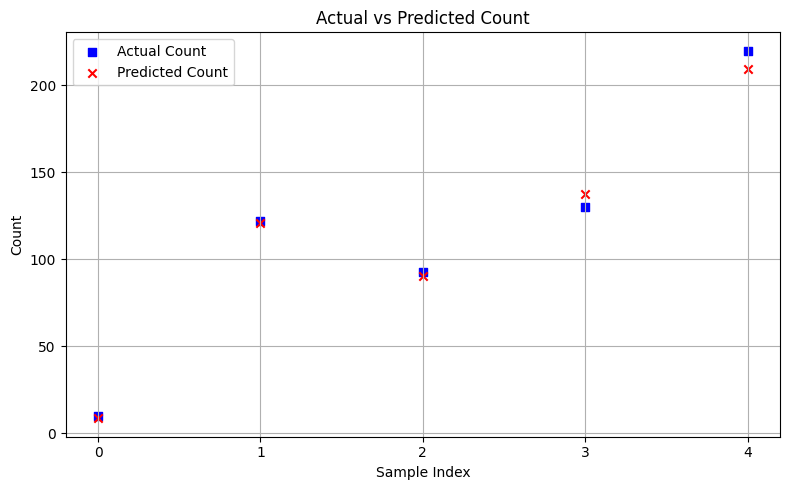

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples
x = np.arange(len(model_output))

plt.figure(figsize=(8, 5))

# Plot actual values as squares
plt.scatter(x, model_output['Actual  Count'], label='Actual Count', marker='s', color='blue')

# Plot predicted values as crosses
plt.scatter(x, model_output['Predicted Count'], label='Predicted Count', marker='x', color='red')

plt.xlabel("Sample Index")
plt.ylabel("Count")
plt.title("Actual vs Predicted Count")
plt.xticks(x)  # Show sample indices clearly
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ Summary
- Loaded the trained model from MLflow Server
- Deployed the model locally using MLflow model server
- Tested the locally deployed model
- Built a REST API for model inference with FastAPI
- Created a Containerfile to containerize the service
- Deployed the container to a Kubernetes (OpenShift) cluster
- Tested the Model-API endpoint successfully

In [ ]:
# Load the training data
# data_path = "./data/processed/"

# # Read both CSV files
# data_01 = pd.read_csv(data_path + 'data_2011_01.csv')
# data_02 = pd.read_csv(data_path + 'data_2011_02.csv')

# # Concatenate the datasets
# # input_data_df = pd.concat([data_01, data_02, data_03], ignore_index=True)
# input_data_df = pd.concat([data_01, data_02], ignore_index=True)

# input_data_df.head()

# sample_input = input_data_df.sample(n=5, random_state=55).reset_index(drop=True)

# sample_input.head()

# # Save the generated sample input to a data under models.
# filename = "./data/test_model/sample_input_data.csv"
# sample_input.to_csv(filename, index=False)
# print(f"Saved {filename}")

# # Load the saved data to see if it was generated and stored properly.
# sample_input_loaded = pd.read_csv('./test_model/sample_input_data.csv')
# sample_input_loaded.head()